In [22]:
import torch
from torch import optim
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import os
import matplotlib.pyplot as plt


In [23]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  # 对卷积层进行 He 初始化
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:  # 对 BatchNorm 层
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:  # 对全连接层
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')


class ResBlock(nn.Module):
    # 图片的尺度不变，只是改变了通道数量
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.22,inplace=True)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 如果输入和输出通道不同，使用 1x1 卷积调整维度
        if in_channels != out_channels:
            self.shortcut = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None
            
        self.apply(weights_init)

    def forward(self, x):
        identity = x  # 保存输入以进行跳跃连接
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.shortcut is not None:
            identity = self.shortcut(x)

        out += identity  # 加入跳跃连接
        out = self.relu(out)
        return out
    
class G(nn.Module):
    def __init__(self, in_dims=1024, out_dim=512):
        super(G, self).__init__()
        self.model = nn.Sequential()

        self.fn1 = nn.Sequential(
            nn.Linear(in_dims, out_dim * 32),
            nn.BatchNorm1d(out_dim * 32),
            nn.ReLU()
        )

        # 第一层线性后 reshape
        self.initial_conv = nn.ConvTranspose2d(in_channels=512*2, out_channels=256*2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.BatchNorm2d1=nn.BatchNorm2d(512)
        self.second_conv = nn.ConvTranspose2d(256*2, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.BatchNorm2d2=nn.BatchNorm2d(64)
        self.third_conv = nn.ConvTranspose2d(64, 48, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.BatchNorm2d3=nn.BatchNorm2d(48)
        self.resblock2 = ResBlock(48, 8)        
        self.final_conv = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.tanh = nn.Tanh()
        self.apply(weights_init)

    def forward(self, x):
        z = self.fn1(x)
        z = z.view(-1, 512*2, 4, 4)
        z = self.initial_conv(z)
        z=self.BatchNorm2d1(z)
        z=self.second_conv(z)
        z=self.BatchNorm2d2(z)

        # 通过残差块
        # z = self.resblock1(z)
        z=self.third_conv(z)
        z=self.BatchNorm2d3(z)
        
        z = self.resblock2(z)

        z = self.final_conv(z)
        return self.tanh(z)
    
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2,inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 如果输入和输出通道不同，使用 1x1 卷积调整维度
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None
        self.apply(weights_init)

    def forward(self, x):
        identity = x  # 保存输入以进行跳跃连接
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.shortcut is not None:
            identity = self.shortcut(x)

        out += identity  # 加入跳跃连接
        out = self.relu(out)
        return out

class D(nn.Module):
    def __init__(self, in_dims=3, dims=32):
        super(D, self).__init__()

        self.model = nn.Sequential()

        def conv_binary_2d(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.15)
            )
        
        # 初始卷积层
        # self.model.append(nn.Conv2d(in_dims, dims, kernel_size=10, stride=8, padding=1))
        self.model.append(nn.Conv2d(in_dims, dims, kernel_size=3, stride=2, padding=1))  # 第一个卷积
        nn.BatchNorm2d(dims),
        self.model.append(nn.LeakyReLU(0.12))
        
      
        self.model.append(conv_binary_2d(dims, 2 * dims))
        nn.BatchNorm2d(2*dims)
        self.model.append(ResBlock2(2 * dims, 4 * dims))  # 添加残差块
        self.model.append(conv_binary_2d(4 * dims, 4 * dims))
        nn.BatchNorm2d(4*dims)
        self.model.append(ResBlock2(4 * dims, 2 * dims))  # 添加残差块
        self.model.append(conv_binary_2d(2 * dims, 1 * dims))
        nn.BatchNorm2d(1*dims)
        nn.LeakyReLU(0.2,inplace=True)
        # 输出层
        self.model.append(nn.Conv2d(1 * dims, 1, kernel_size=4))
        
        self.sigm=nn.Sigmoid()
        self.apply(weights_init)

    def forward(self, x):
        z = self.model(x)
        z = z.view(-1)
        z=self.sigm(z)
        return z
    
    

C:\Users\touka\AppData\Local\Temp\ipykernel_21656\3665461518.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_model.load_state_dict(torch.load('rem_gen_v1.pth'))


Models loaded successfully.


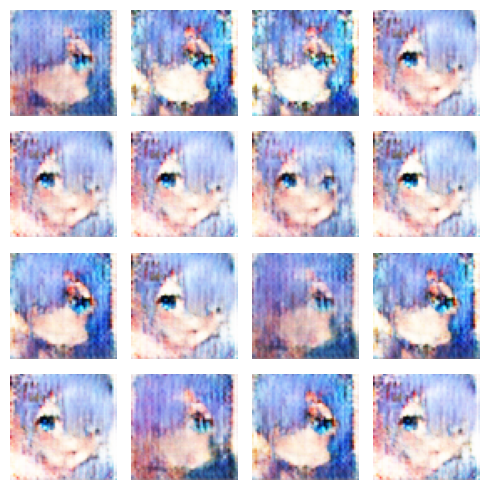

In [24]:
mode="TEST"
G_model = G(in_dims=128).cuda()
if mode == "TEST":
    # Load the models
    G_model.load_state_dict(torch.load('rem_gen_v1.pth'))
    # D_model.load_state_dict(torch.load('discriminator.pth'))
    print("Models loaded successfully.")
else:
    print("No saved models found. Starting training from scratch.")

device='cuda'



with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    fake_images = G_model(z).cpu()
    fake_images = (fake_images + 1) / 2  # Denormalize
    
    fig, axs = plt.subplots(4, 4, figsize=(5, 5))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(fake_images[i*4 + j].permute(1, 2, 0))
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(f'./logs/GAN_rem.png')
    plt.show()